In [6]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import itertools
import time
from tqdm import tqdm
import sympy as sp
x = sp.var('x')
from sympy import Symbol
from sympy.solvers import solve
import math
import matplotlib.pyplot as plt
import collections

import warnings
warnings.filterwarnings("ignore")

from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

# Import our adaptive module:
from adaptive_MDP import Adaptive
import MDP

In [53]:
# ================================================== #

# Initial parameters (Example from Fenichel et al):
mu = 0
gamma = 0.1823
beta = 0.0825
phi = 0

# R values:
Rmu = mu/(mu+ gamma)
Rphi = phi/(mu + gamma)

### Adaptive parameters

# Quadratic Utility functions:

b_s = 10 # Making the max utility attained at b_s/2 
b_i = 6.67 # Making the max utility attained at b_i/2 
b_z = 10 # Making the max utility attained at b_z/2 
a_s = 0
a_i = 1.826
a_z = 0
nu = 0.25
tau = 12
delta = 0.99986

# ================================================== #

# Immediate rewards: (Utility functions)
def u_s(a):
    return ((b_s*a - a**2)**nu)*((b_s*a - a**2)**nu) - a_s
def u_i(a):
    return (b_i*a - a**2)**nu - a_i
def u_z(a):
    return (b_z*a - a**2)**nu - a_z

### Simulation parameters
t_max = 150
steps = 100

In [54]:
# # Initial parameters Our example with relapse (from chapter 2)----- #
# mu = 0.00015
# gamma = 0.0027
# beta = 0.00096
# phi = 0.0044

# # R values:
# Rmu = mu/(mu+ gamma)
# Rphi = phi/(mu + gamma)

# ### Adaptive parameters

# # Quadratic Utility functions:

# b_s = 24 # Making the max utility attained at b_s/2 
# b_i = 20 # Making the max utility attained at b_i/2 
# b_z = 30 # Making the max utility attained at b_z/2 
# a_s = 0
# a_i = 0
# a_z = 0
# nu = 0.01375
# tau = 30
# delta = 0.9986

# # Immediate rewards:
# def u_s(a):
#     return (b_s*a - a**2)**nu - a_s
# def u_i(a):
#     return (b_i*a - a**2)**nu - a_i
# def u_z(a):
#     return (b_z*a - a**2)**nu - a_z

# ### Simulation parameters
# t_max = 5000
# steps = 100

In [55]:
x00 = [2000, 4000, 4000]
# Initialize adaptive instances
instance_adaptive = Adaptive(
    mu, gamma, beta, phi,
    tau, delta,
    u_s, u_i, u_z,
    t_max, steps, x00, max_contacts=30,
    logs=False, verbose=False,
    compute_max_t_threshold=1e-6)
states = [0, 1, 2]
actions = instance_adaptive.actions
horizon = instance_adaptive.tau
delta = instance_adaptive.delta

xt_start = [instance_adaptive.x00[0], instance_adaptive.x00[1], instance_adaptive.x00[1]]
cs_star, ci_star, cz_star = instance_adaptive.cs_max, instance_adaptive.ci_max, instance_adaptive.cz_max

s_proj, i_proj, z_proj = instance_adaptive.solve_odes_system_projection(
    x0=xt_start, t0=0, cs=cs_star, ci=ci_star, cz=cz_star)

trans_probs = []
for tt in range(horizon):

    # Transition Probabilities (at time t):
    # Using the system projection

    def P_si(a):
        phi_t = s_proj[tt*instance_adaptive.steps]*cs_star + i_proj[tt*instance_adaptive.steps]*ci_star + z_proj[tt*instance_adaptive.steps]*cz_star
        P_it = 1 - math.exp(-1*(instance_adaptive.beta*ci_star*i_proj[tt*instance_adaptive.steps]*a)/phi_t)
        return P_it

    def P_ss(a):
        return 1 - P_si(a)

    def P_sz(a):
        return 0

    def P_is(a):
        return 0

    def P_ii(a):
        return math.exp(-1*instance_adaptive.gamma)

    def P_iz(a):
        return 1 - math.exp(-1*instance_adaptive.gamma)

    def P_zs(a):
        return 0

    def P_zi(a):
        if instance_adaptive.phi == 0:
            return 0
        return P_si(a)*0.97

    def P_zz(a):
        return 1 - P_zi(a)

    trans_prob_mat = np.array([
        [P_ss, P_si, P_sz],
        [P_is, P_ii, P_iz],
        [P_zs, P_zi, P_zz]
    ])
    trans_probs.append(trans_prob_mat)

reward_vector = np.array([instance_adaptive.u_s, instance_adaptive.u_i, instance_adaptive.u_z])
rewards = [reward_vector]*horizon

"""
Initialization point for MDP process
"""

if instance_adaptive.init_point:
    init_point_use = instance_adaptive.init_point
else:
    init_point_use = [np.nanmax([instance_adaptive.u_s(a) for a in actions]),
                      0,
                      np.nanmax([instance_adaptive.u_z(a) for a in actions])]

# Use a Markov Decision Process with finite horizon to obtain the optimal policy and decision.
MDP_adaptive = MDP.MDP(states, actions, rewards, trans_probs, horizon, delta,
                       logger=instance_adaptive.logger, verbose=instance_adaptive.verbose)
MDP_adaptive.fit_optimal_values(init_point=init_point_use)
values_history = MDP_adaptive.values_history

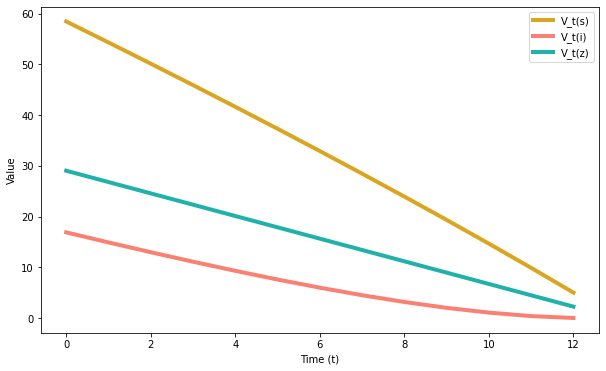

In [56]:
plt.plot(range(len(values_history[0])), values_history[0], 'goldenrod', label="V_t(s)", linewidth=4,)
plt.plot(range(len(values_history[1])), values_history[1], 'salmon', label="V_t(i)", linewidth=4,)
plt.plot(range(len(values_history[2])), values_history[2], 'lightseagreen', label="V_t(z)", linewidth=4,)
plt.xlabel("Time (t)")
plt.ylabel("Value")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

In [35]:
MDP_adaptive.policies

[{0: 10.606060606060606, 1: 10.0, 2: 12.424242424242424},
 {0: 10.606060606060606, 1: 10.0, 2: 12.424242424242424},
 {0: 10.606060606060606, 1: 10.0, 2: 12.424242424242424},
 {0: 10.606060606060606, 1: 10.0, 2: 12.424242424242424},
 {0: 10.606060606060606, 1: 10.0, 2: 12.424242424242424},
 {0: 10.606060606060606, 1: 10.0, 2: 12.424242424242424},
 {0: 10.606060606060606, 1: 10.0, 2: 12.424242424242424},
 {0: 10.606060606060606, 1: 10.0, 2: 12.424242424242424},
 {0: 10.606060606060606, 1: 10.0, 2: 12.424242424242424},
 {0: 10.606060606060606, 1: 10.0, 2: 12.424242424242424},
 {0: 10.606060606060606, 1: 10.0, 2: 12.424242424242424},
 {0: 10.303030303030303, 1: 10.0, 2: 12.424242424242424},
 {0: 10.303030303030303, 1: 10.0, 2: 12.424242424242424},
 {0: 10.303030303030303, 1: 10.0, 2: 12.424242424242424},
 {0: 10.303030303030303, 1: 10.0, 2: 12.424242424242424},
 {0: 10.303030303030303, 1: 10.0, 2: 12.424242424242424},
 {0: 10.303030303030303, 1: 10.0, 2: 12.424242424242424},
 {0: 10.303030